In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle

print(tf.__version__) 


Found GPU at: 
2.2.0


In [2]:
from IPython.display import clear_output, display
import os.path
from os import path
import shutil
import PIL
from pathlib import Path
from matplotlib import pyplot as plt

In [3]:
BASE_DIR= '/mestrado/datasets'
IMG_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_orig', 'images')
LABELS_ORG_DIR= path.join( BASE_DIR, 'carnaval_8lines_shuffle_orig', 'labels')

In [4]:
def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def write_label( path, text):
  f= open( path, "w")
  f.write( text)
  f.close()

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

def show_gimage( img, name= 'noname'):
  plt.imshow( img, cmap= 'gray')
  plt.title( name)
  plt.show()

def _load_image( path):
  # return cv2.imread( path, cv2.IMREAD_GRAYSCALE)
  return cv2.imread( path)
  
def write_image( path, img):
  cv2.imwrite( path, img)

def resize( img, scale_percent= 60, verbose=False):
  #scale_percent = 60 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  if verbose:
    print( "scale", scale_percent)
    print( "dim", dim)
  # resize image
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

In [5]:
def _load_all():
    all_images= glob( os.path.join( IMG_ORG_DIR, "*.jpg"))
    # all_images= glob( '/content/carnaval_8lines/images/*.jpg')
    all_images.sort()
    all_images_content= [_load_image( f) for f in all_images]    
    all_images_content= np.asarray( all_images_content)

    all_labels=glob( os.path.join( LABELS_ORG_DIR, "*.pgn"))
    all_labels.sort()

    #ler todo o conteudo de labels e criar o vocabulario
    all_labels_content= [read_label( f) for f in all_labels]
    all_labels_content= [label.split() for label in all_labels_content]

    # pega somente os primeiros 4, equivalente a 1 poagina
    all_labels_content= [x[0:16] for x in all_labels_content]

    #complementa onde falta para completar 100
    all_labels_content= [
                np.pad( x, (0,16-len(x)), 'constant', constant_values= 'end') for x in all_labels_content]
    return all_images, all_images_content, all_labels, all_labels_content


def cut( img, lines, cols):
    cuts= []
    h= (int)(img.shape[ 0]/lines)
    w= (int)(img.shape[ 1]/cols)

    for i in range(0,lines):
      for j in range(0,cols):
        cuts.append( img[ (i*h):(i+1)*h, (j*w):(j+1)*w])
    return np.array( cuts)

def rebuild( cuts):
    return np.concatenate( 
        (np.concatenate( (cuts[0], cuts[2], cuts[4], cuts[6], cuts[8], cuts[10], cuts[12], cuts[14]), axis=0),
        np.concatenate( (cuts[1], cuts[3], cuts[5], cuts[7], cuts[9], cuts[11], cuts[13], cuts[15]), axis=0)),
        axis= 1
    )

def _shuffle( img, label, k):
    cuts= cut( img, 8, 2)

    # newcuts, newlabel= np.random.shuffle( cuts)
    newcuts, newlabel= shuffle( cuts, label, random_state= k)
    newimg= rebuild( newcuts)
    return newimg, newlabel


In [6]:
all_images, all_image_content, all_labels, label_content= _load_all()

In [7]:
len( all_images)

136

In [ ]:
def isok( s):
    return int( s[9:13])<= 114

oklist= list( filter( lambda x: isok( os.path.basename(x)), all_images))

In [ ]:
def isok( s):
    return 'x' in s or '+' in s

oklist= list( filter( lambda x: isok( os.path.basename(x)), all_images))

In [15]:
'f' in 'jdkfl a' or 'p' in 'jdkfl a'

True

In [16]:
' '.join( label_content[0])

array(['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'Nf6', 'Nc3', 'd6',
       'Bb5+', 'Nbd7', 'O-O', 'Be7', 'Be3', 'O-O'], dtype='<U4')

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bb5+' 'Nbd7'
 'O-O' 'Be7' 'Be3' 'O-O']


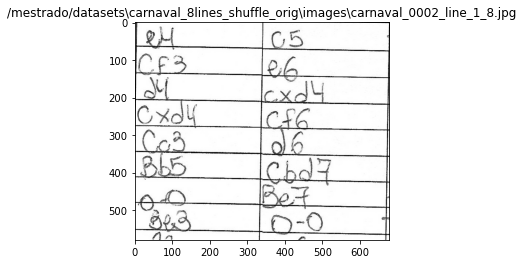

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'a6' 'c4' 'Qc7' 'Nc3' 'Nf6' 'Be3'
 'Bb4' 'Qd2' 'Nxe4']


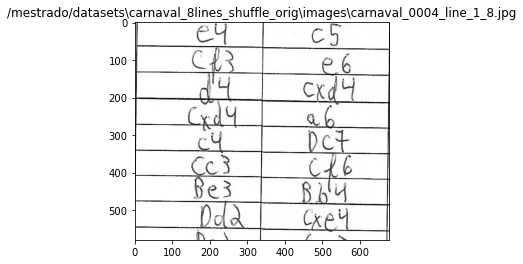

['e4' 'c5' 'Nf3' 'd6' 'Bb5+' 'Bd7' 'Bxd7+' 'Nxd7' 'O-O' 'Ngf6' 'Re1' 'e5'
 'c3' 'Be7' 'd3' 'O-O']


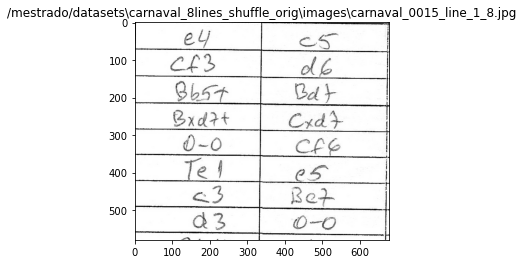

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'g6' 'Nc3' 'Bg7' 'Be3' 'Nf6'
 'Bc4' 'O-O' 'Bb3' 'd6']


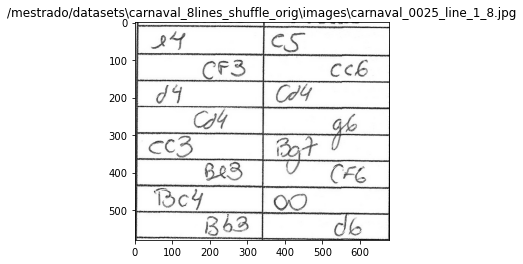

['e4' 'e5' 'Nf3' 'd6' 'Nc3' 'Nc6' 'Bc4' 'Be7' 'h3' 'Nf6' 'd4' 'exd4'
 'Nxd4' 'Nxd4' 'Qxd4' 'O-O']


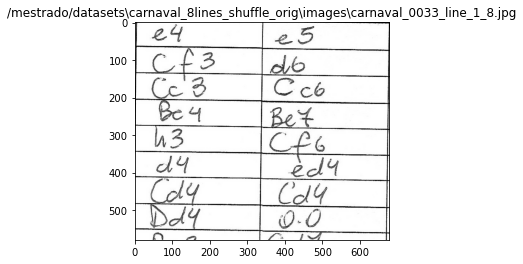

['g3' 'd5' 'Bg2' 'Nf6' 'c4' 'c6' 'Nf3' 'dxc4' 'Qc2' 'b5' 'a4' 'Bb7' 'b3'
 'cxb3' 'Qxb3' 'a6']


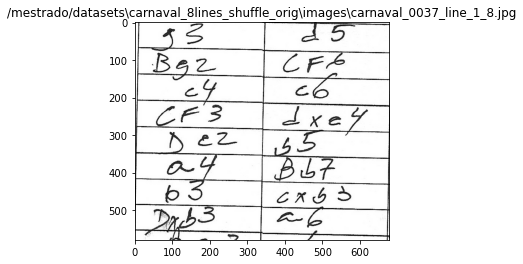

['e4' 'e5' 'Nf3' 'Nc6' 'Bc4' 'Nf6' 'Ng5' 'd5' 'exd5' 'Na5' 'Bb5+' 'c6'
 'dxc6' 'bxc6' 'Bd3' 'Nd5']


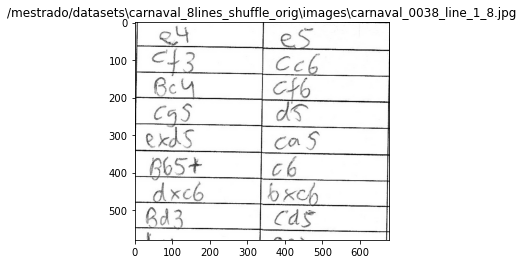

['c4' 'e5' 'Nc3' 'Nf6' 'g3' 'c5' 'e3' 'Nc6' 'Nge2' 'Bd6' 'Bg2' 'b6' 'O-O'
 'Bb7' 'd4' 'exd4']


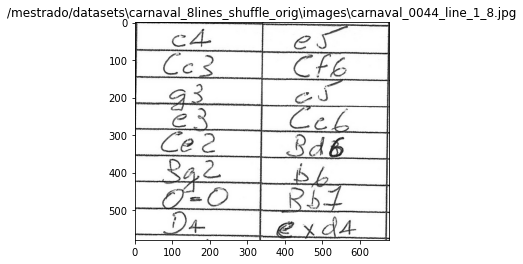

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'e6' 'Be2' 'Bc5' 'Be3' 'Qb6'
 'c3' 'Bxd4' 'Bxd4' 'Nxd4']


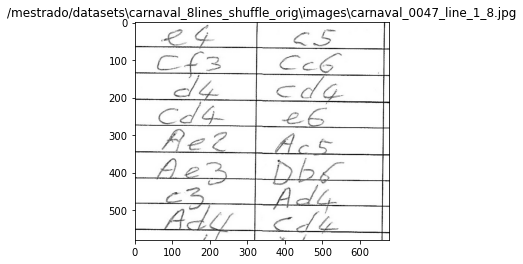

['e4' 'c6' 'Nf3' 'd5' 'e5' 'Bg4' 'd4' 'e6' 'Bd3' 'c5' 'c3' 'Nc6' 'Be3'
 'Qb6' 'Nbd2' 'Qxb2']


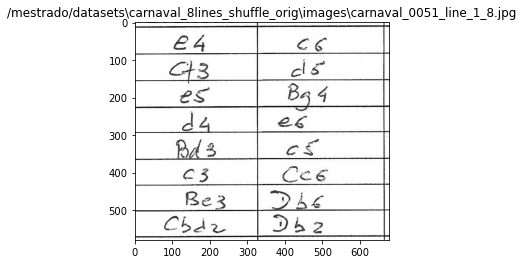

['d4' 'Nf6' 'c4' 'e6' 'Nf3' 'd5' 'cxd5' 'exd5' 'Bg5' 'c6' 'Nc3' 'Be7'
 'Bxf6' 'Bxf6' 'e3' 'O-O']


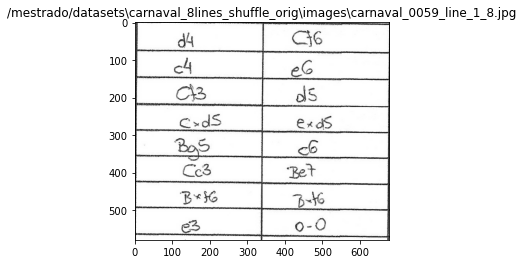

['g3' 'd5' 'Bg2' 'Nf6' 'c4' 'c6' 'Nf3' 'dxc4' 'Qc2' 'b5' 'a4' 'Bb7' 'b3'
 'cxb3' 'Qxb3' 'a6']


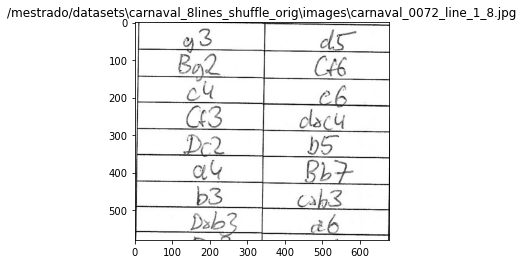

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'Be3' 'Bg7' 'f3'
 'Nc6' 'Qd2' 'O-O']


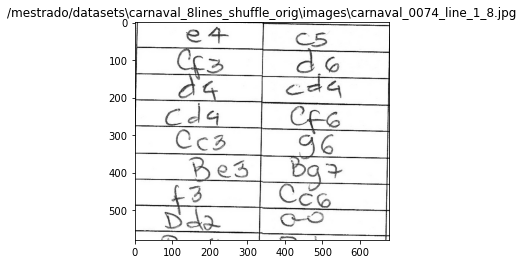

['e4' 'e5' 'Nf3' 'Nc6' 'Bc4' 'Bc5' 'b4' 'Bxb4' 'c3' 'Be7' 'd4' 'd6' 'Be3'
 'Nf6' 'Nbd2' 'O-O']


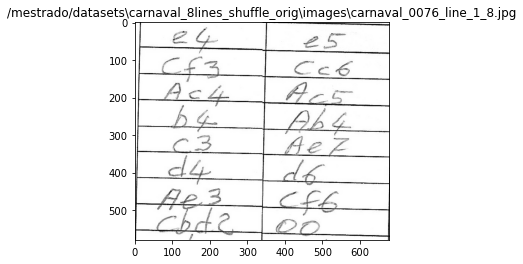

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'e5' 'Nb3' 'Bb4'
 'Bd3' 'd5' 'exd5' 'Nxd5']


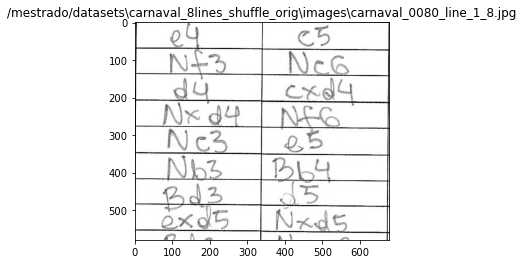

['e4' 'c5' 'c3' 'Nf6' 'e5' 'Nd5' 'Nf3' 'e6' 'd4' 'cxd4' 'cxd4' 'Nc6' 'Bb5'
 'Qa5+' 'Nc3' 'Nxc3']


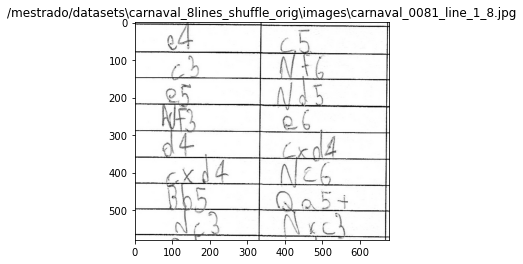

['d4' 'Nf6' 'Bf4' 'g6' 'e3' 'Bg7' 'Qd3' 'O-O' 'Qc3' 'Nd5' 'Bxc7' 'Qxc7'
 'Qd2' 'Nc6' 'e4' 'Nb6']


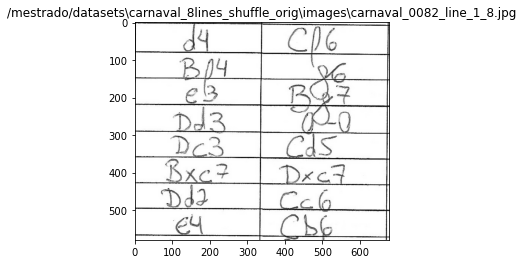

['e4' 'e6' 'd4' 'd5' 'Nc3' 'Bb4' 'e5' 'c5' 'a3' 'Bxc3+' 'bxc3' 'Ne7'
 'Bb5+' 'Bd7' 'a4' 'Qa5']


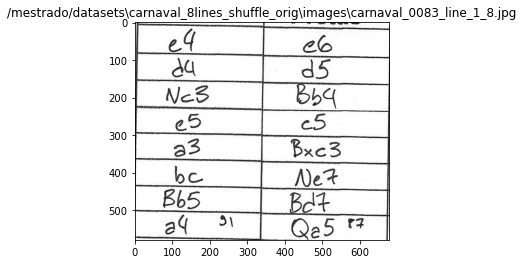

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'h3' 'e5' 'Nde2'
 'h5' 'Bg5' 'Be6']


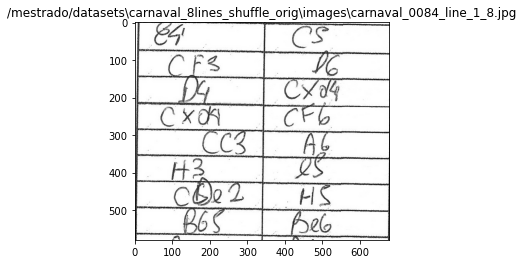

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Bg5' 'e6' 'f3'
 'Be7' 'Qd2' 'O-O']


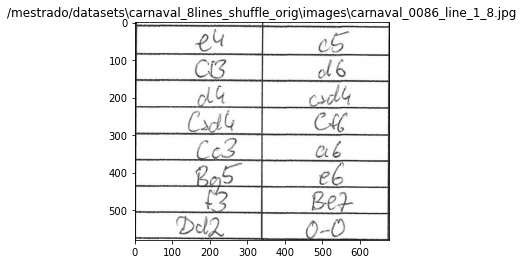

['e4' 'e5' 'Nf3' 'Nc6' 'Bb5' 'a6' 'Bxc6' 'dxc6' 'O-O' 'Bd6' 'd3' 'Ne7'
 'Be3' 'O-O' 'c3' 'Ng6']


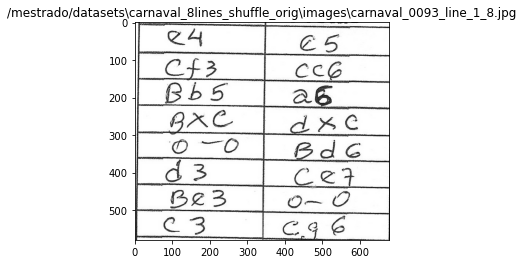

['e4' 'Nf6' 'Bd3' 'e5' 'c3' 'd5' 'Qe2' 'Nc6' 'exd5' 'Qxd5' 'f3' 'Be6'
 'Bc2' 'Qc5' 'd3' 'Nd5']


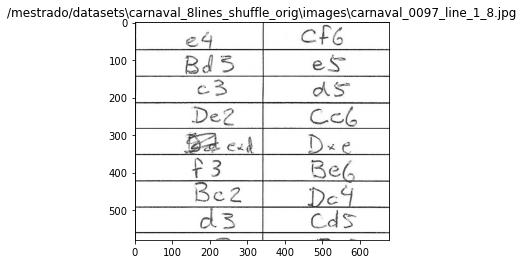

['e4' 'e6' 'd4' 'd5' 'Nc3' 'Bb4' 'e5' 'c5' 'a3' 'Bxc3+' 'bxc3' 'Ne7'
 'Bb5+' 'Bd7' 'a4' 'Qa5']


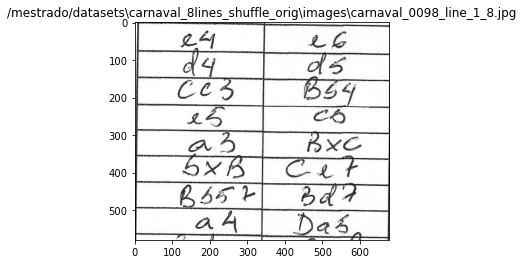

['e4' 'c5' 'Nf3' 'd6' 'c3' 'g6' 'd4' 'cxd4' 'cxd4' 'Bg7' 'h3' 'a6' 'Nc3'
 'Nc6' 'Be2' 'Nf6']


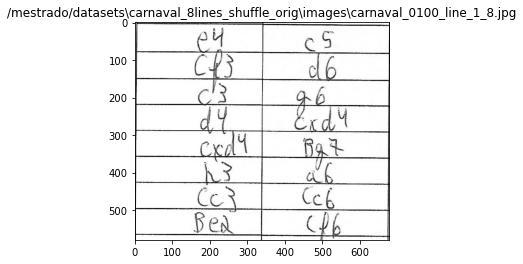

['e4' 'e5' 'Nf3' 'Nc6' 'Bc4' 'Bc5' 'b4' 'Bxb4' 'c3' 'Be7' 'd4' 'd6' 'Be3'
 'Nf6' 'Nbd2' 'O-O']


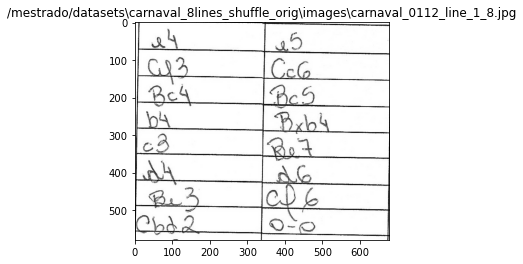

['d4' 'Nf6' 'c4' 'e6' 'Nc3' 'Bb4' 'e3' 'O-O' 'a3' 'Bxc3+' 'bxc3' 'c5'
 'Bd3' 'Nc6' 'Ne2' 'd6']


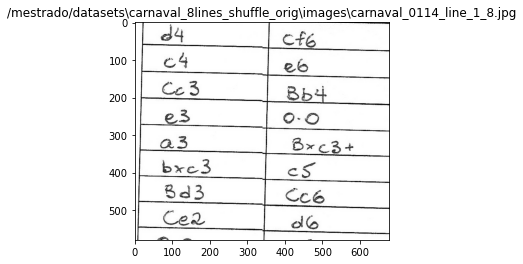

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'e5' 'Nb3' 'Bb4'
 'Bd3' 'd5' 'exd5' 'Nxd5']


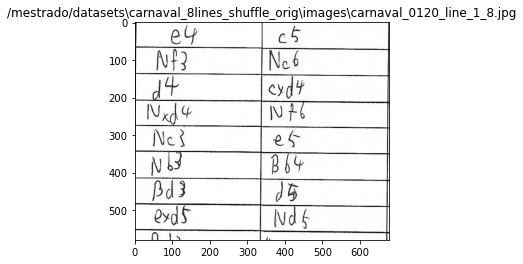

['Nf3' 'Nf6' 'g3' 'd5' 'Bg2' 'Bg4' 'c4' 'Bxf3' 'Bxf3' 'c6' 'd4' 'e6' 'O-O'
 'Be7' 'Nc3' 'O-O']


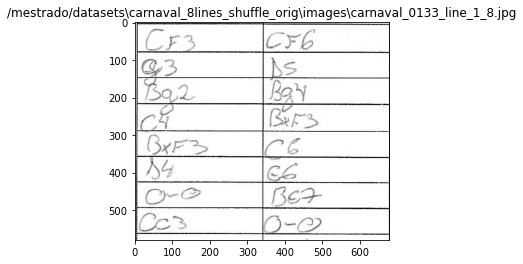

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'Nbd7' 'Be2' 'a6'
 'O-O' 'e6' 'Bf3' 'Be7']


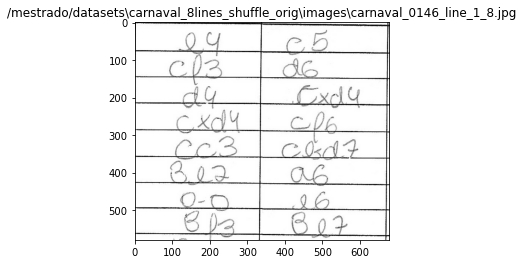

['d4' 'Nf6' 'c4' 'g6' 'Nc3' 'd5' 'Nf3' 'Bg7' 'Qb3' 'dxc4' 'Qxc4' 'a6'
 'Bf4' 'b5' 'Qxc7' 'Qxc7']


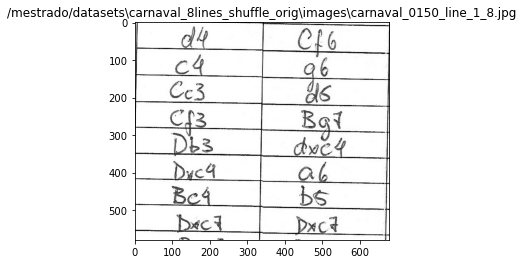

['c4' 'd6' 'g3' 'Nf6' 'Bg2' 'Nc6' 'Nc3' 'Bf5' 'Nf3' 'Nb4' 'Qa4+' 'Nc6'
 'd4' 'e6' 'd5' 'exd5']


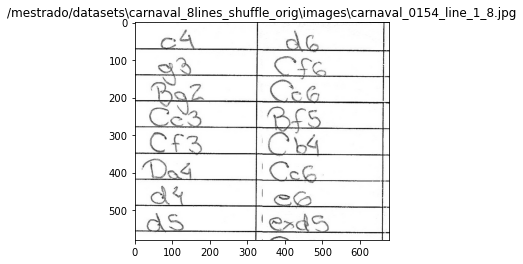

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'e6' 'Nc3' 'a6' 'Nxc6' 'bxc6'
 'Bd3' 'd5' 'O-O' 'Nf6']


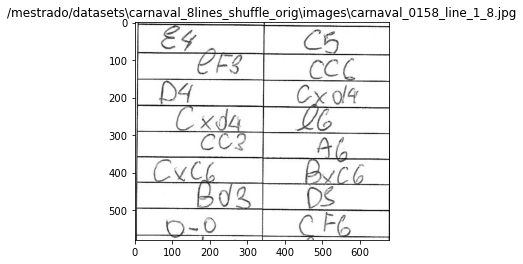

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Bc4' 'e6' 'O-O'
 'Be7' 'f4' 'O-O']


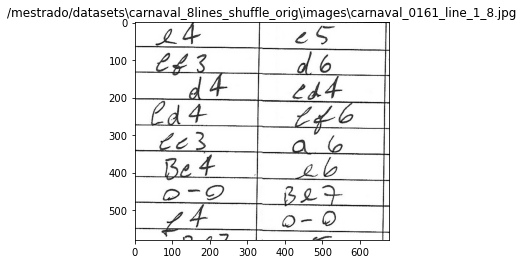

['e4' 'e6' 'd4' 'd5' 'Nc3' 'Bb4' 'e5' 'c5' 'a3' 'Bxc3+' 'bxc3' 'Qc7' 'Qg4'
 'f5' 'Qh5+' 'g6']


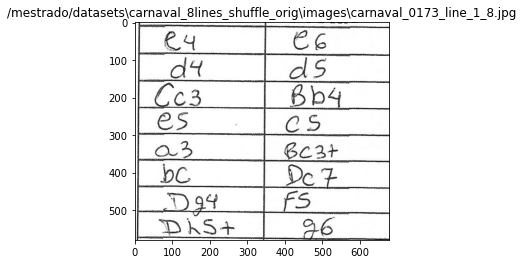

['e4' 'e6' 'd4' 'd5' 'Nc3' 'c5' 'e5' 'Qb6' 'Nf3' 'Bd7' 'Rb1' 'Nc6' 'Be3'
 'Nge7' 'dxc5' 'Qa5']


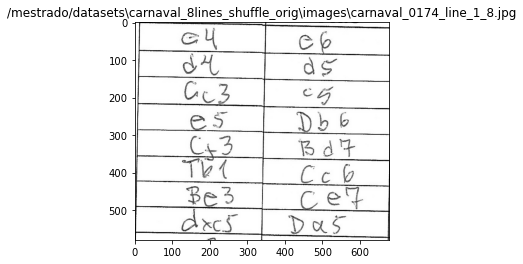

['b4' 'd5' 'Bb2' 'Nf6' 'd3' 'Bf5' 'Nd2' 'e6' 'a3' 'c5' 'b5' 'Qb6' 'Bxf6'
 'gxf6' 'c4' 'a6']


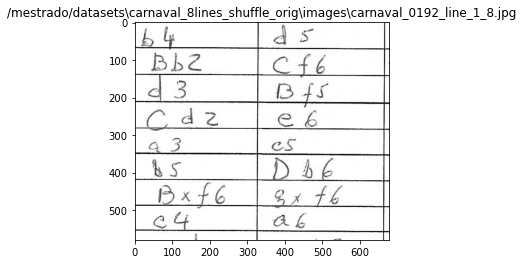

['d4' 'e6' 'Bf4' 'd5' 'Nf3' 'c6' 'e3' 'Bd6' 'Bxd6' 'Qxd6' 'Nbd2' 'Nf6'
 'Bd3' 'O-O' 'O-O' 'Nbd7']


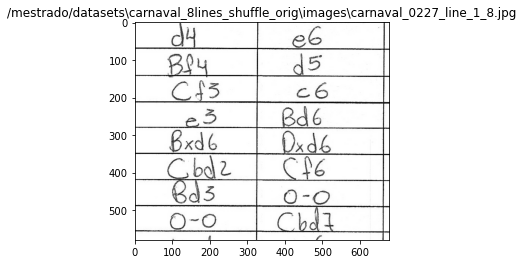

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'e6' 'Nc3' 'a6' 'Nxc6' 'bxc6'
 'Bd3' 'd5' 'O-O' 'Nf6']


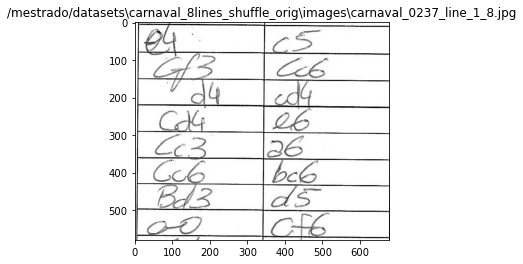

['c4' 'e5' 'Nc3' 'Nf6' 'g3' 'd5' 'cxd5' 'Nxd5' 'Bg2' 'Nc6' 'e3' 'Nb6'
 'Nge2' 'Nb4' 'd4' 'exd4']


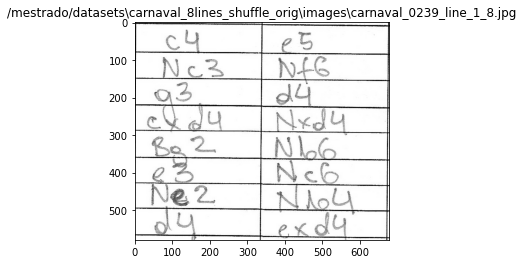

['c4' 'e5' 'Nc3' 'Nf6' 'g3' 'd5' 'cxd5' 'Nxd5' 'Bg2' 'Nc6' 'e3' 'Nb6'
 'Nge2' 'Nb4' 'd4' 'exd4']


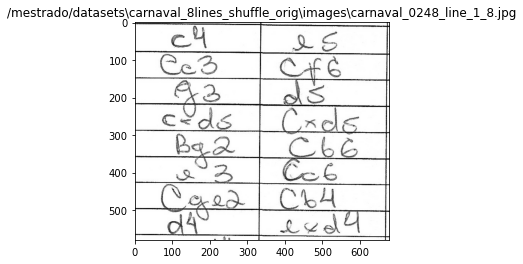

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'Be2' 'Bg7'
 'O-O' 'O-O' 'Be3' 'Nc6']


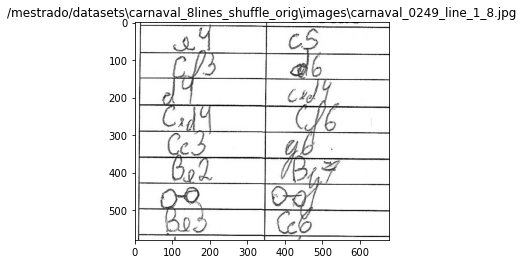

['e4' 'c5' 'Nf3' 'd6' 'c3' 'Nf6' 'Bc4' 'Nc6' 'Qe2' 'g6' 'h3' 'Bg7' 'O-O'
 'O-O' 'd4' 'cxd4']


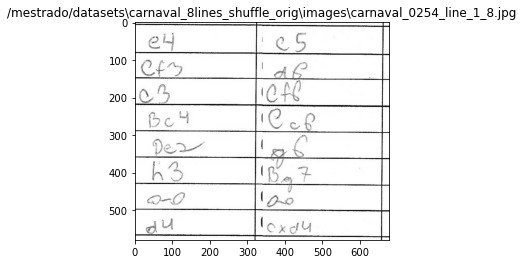

['d4' 'e6' 'Bf4' 'd5' 'Nf3' 'c6' 'e3' 'Bd6' 'Bxd6' 'Qxd6' 'Nbd2' 'Nf6'
 'Bd3' 'O-O' 'O-O' 'Nbd7']


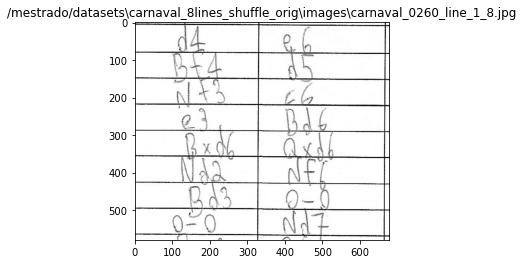

['Nc3' 'Ne4' 'Nxe4' 'Bxe4' 'O-O' 'O-O' 'Ne1' 'Bxg2' 'Nxg2' 'd5' 'Qa4'
 'Qd7' 'Qxd7' 'Nxd7' 'cxd5' 'exd5']


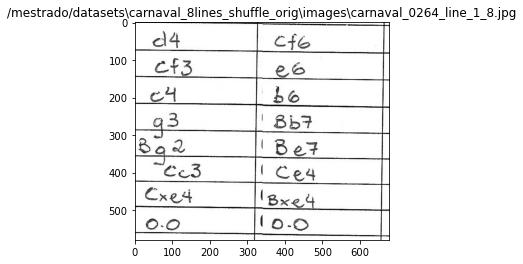

['e4' 'c6' 'd4' 'd5' 'exd5' 'cxd5' 'c4' 'dxc4' 'Bxc4' 'e6' 'Nf3' 'Bd6'
 'O-O' 'Nf6' 'Bg5' 'O-O']


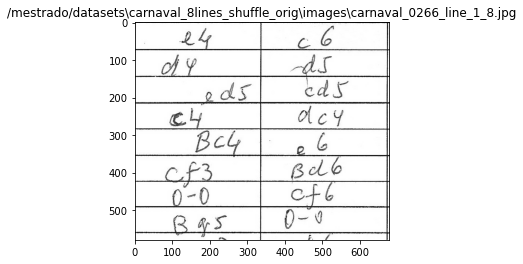

['e4' 'e6' 'd4' 'd5' 'Nc3' 'Nf6' 'Bg5' 'dxe4' 'Nxe4' 'Be7' 'Nxf6+' 'Bxf6'
 'Bxf6' 'Qxf6' 'Bd3' 'c5']


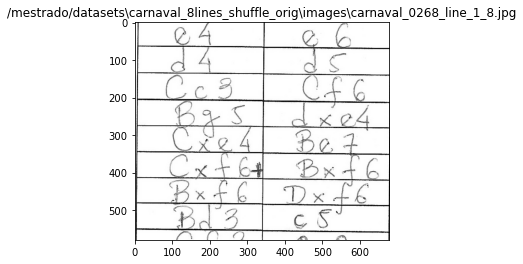

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Bg5' 'e6' 'f4'
 'Be7' 'Qf3' 'Qc7']


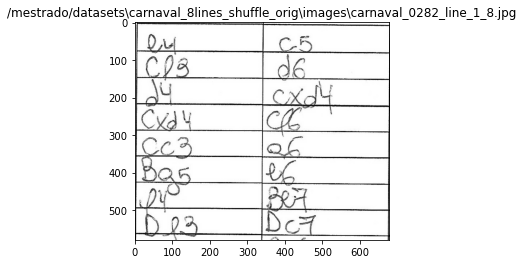

['e4' 'e5' 'Nf3' 'Nc6' 'Bc4' 'Bc5' 'c3' 'Nf6' 'd4' 'exd4' 'cxd4' 'Bb4+'
 'Bd2' 'Bxd2+' 'Nbxd2' 'd5']


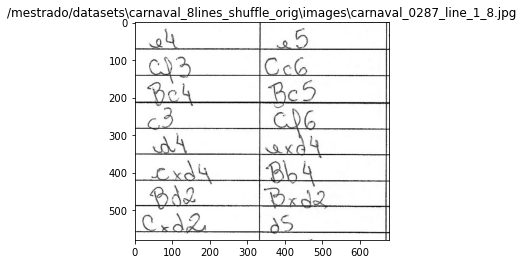

['e4' 'c6' 'd4' 'd5' 'exd5' 'cxd5' 'c4' 'dxc4' 'Bxc4' 'e6' 'Nf3' 'Bd6'
 'O-O' 'Nf6' 'Bg5' 'O-O']


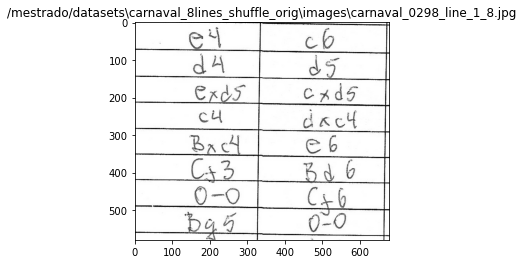

['d4' 'Nf6' 'Bf4' 'e6' 'e3' 'c5' 'c3' 'd5' 'Be2' 'Nc6' 'Nf3' 'Bd6' 'Bxd6'
 'Qxd6' 'Bb5' 'O-O']


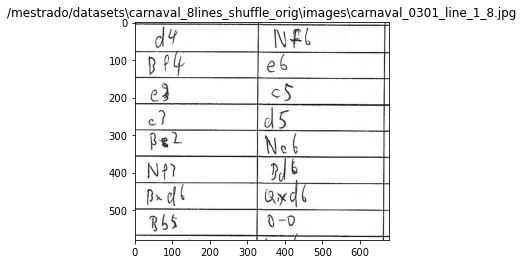

['d4' 'Nf6' 'Nf3' 'c5' 'g3' 'g6' 'Bg2' 'Bg7' 'O-O' 'O-O' 'c4' 'cxd4'
 'Nxd4' 'd6' 'Nc3' 'Nbd7']


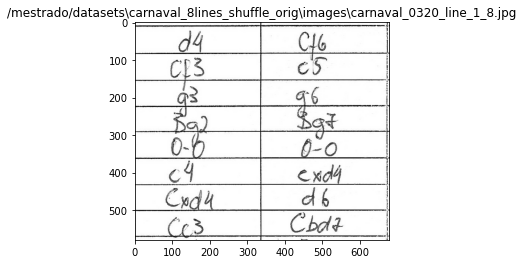

['c4' 'Nf6' 'Nc3' 'e6' 'Nf3' 'Bb4' 'Qc2' 'h6' 'a3' 'Bxc3' 'Qxc3' 'b6' 'b4'
 'Bb7' 'Bb2' 'd5']


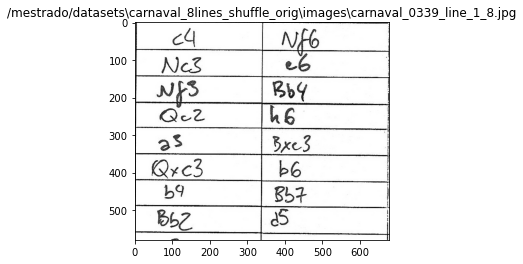

['e4' 'e6' 'd4' 'd5' 'exd5' 'exd5' 'Bd3' 'c5' 'dxc5' 'Bxc5' 'Nf3' 'Nc6'
 'O-O' 'Nge7' 'Nbd2' 'Bg4']


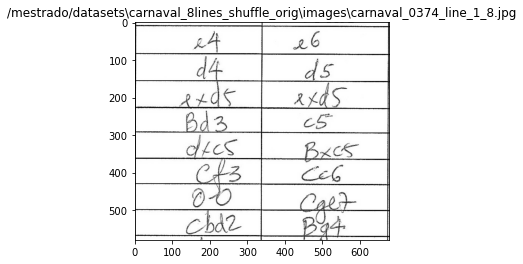

['d4' 'Nf6' 'c4' 'e6' 'g3' 'd5' 'Bg2' 'Be7' 'Nf3' 'O-O' 'O-O' 'dxc4' 'Ne5'
 'Nc6' 'Nxc6' 'bxc6']


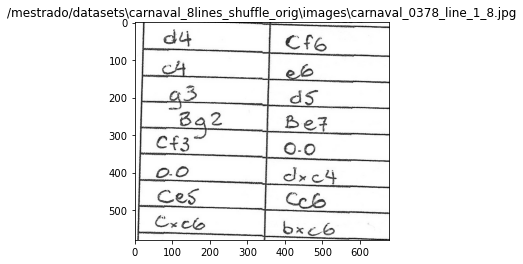

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'g3' 'Bg7' 'Bg2'
 'Nc6' 'O-O' 'O-O']


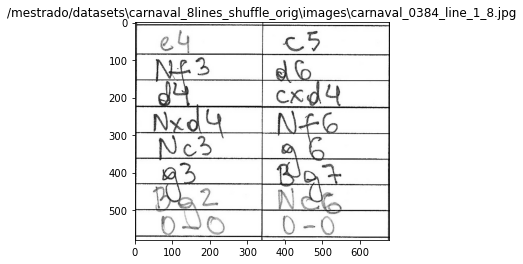

['d4' 'Nf6' 'Nf3' 'e6' 'c4' 'Bb4+' 'Bd2' 'a5' 'Nc3' 'O-O' 'Qc2' 'd5' 'e3'
 'b6' 'Bd3' 'Bb7']


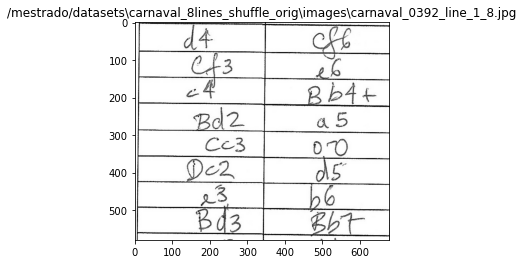

['Nf3' 'Nf6' 'g3' 'g6' 'b3' 'Bg7' 'Bb2' 'O-O' 'Bg2' 'c5' 'c4' 'd5' 'cxd5'
 'Nxd5' 'Bxg7' 'Kxg7']


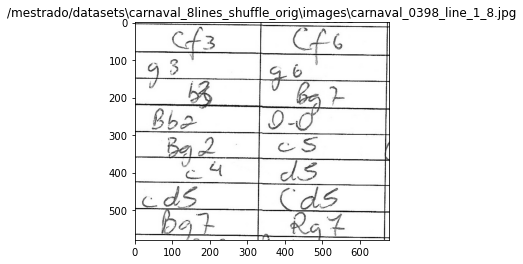

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bg5' 'e6'
 'Qd2' 'Be7' 'O-O-O' 'd5']


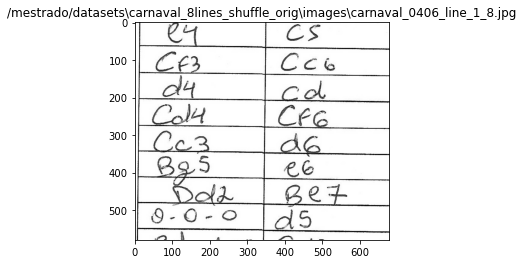

['d4' 'd5' 'Nf3' 'Nf6' 'Bg5' 'e6' 'c4' 'Be7' 'e3' 'O-O' 'Bd3' 'dxc4'
 'Bxc4' 'a6' 'O-O' 'b5']


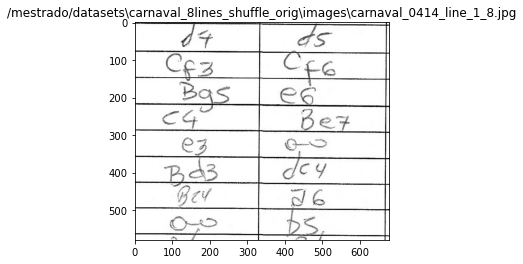

['d4' 'Nf6' 'c4' 'e6' 'Nf3' 'd5' 'Nc3' 'Be7' 'Bf4' 'O-O' 'e3' 'b6' 'Bd3'
 'dxc4' 'Bxc4' 'Bb7']


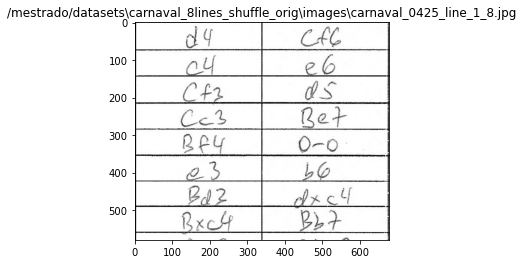

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Be2' 'a6' 'Bf3'
 'Nbd7' 'O-O' 'Qc7']


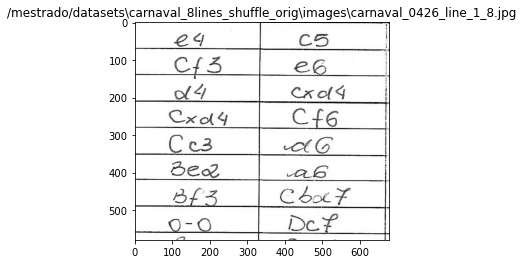

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'f4' 'Nc6' 'Bb5'
 'Bd7' 'Be3' 'Bg7']


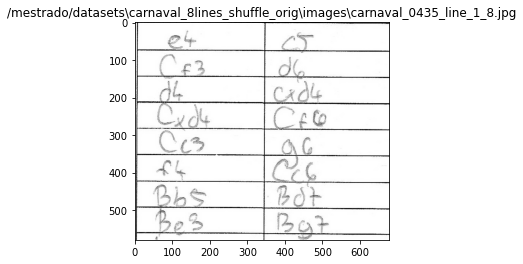

['e4' 'c5' 'c3' 'g6' 'd4' 'cxd4' 'cxd4' 'd5' 'e5' 'Nc6' 'Nf3' 'Bg4' 'Bb5'
 'e6' 'O-O' 'Qb6']


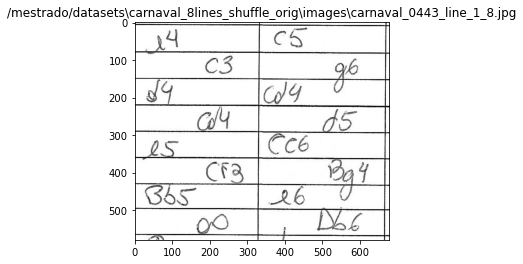

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bg5' 'e6'
 'Qd2' 'Be7' 'O-O-O' 'd5']


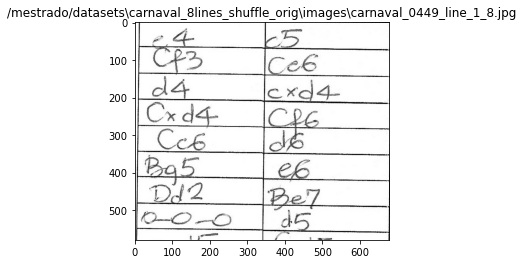

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'a6' 'Nc3' 'Qc7' 'Be3' 'Nf6' 'a3'
 'Nc6' 'Qd2' 'd6']


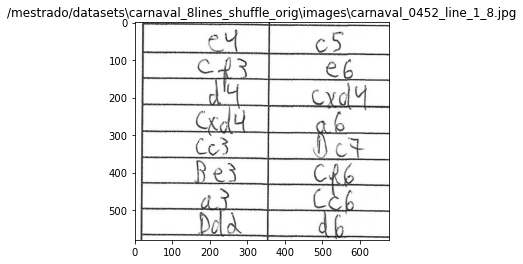

['e4' 'e5' 'Nf3' 'd6' 'd4' 'exd4' 'Qxd4' 'Nc6' 'Bb5' 'Bd7' 'Bxc6' 'Bxc6'
 'Nc3' 'Qd7' 'Bf4' 'Nf6']


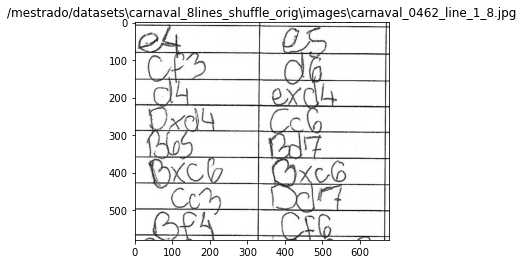

['d4' 'd5' 'c4' 'c6' 'Nc3' 'Nf6' 'Bf4' 'e6' 'e3' 'Bd6' 'Nf3' 'O-O' 'Qc2'
 'Bxf4' 'exf4' 'Qd6']


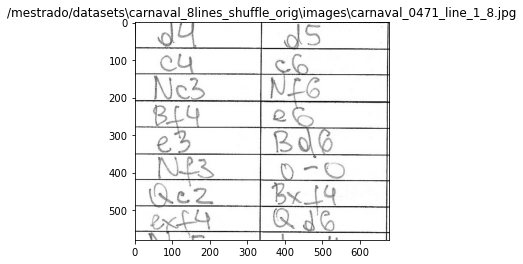

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'g3' 'Bg7' 'Bg2'
 'Nc6' 'O-O' 'O-O']


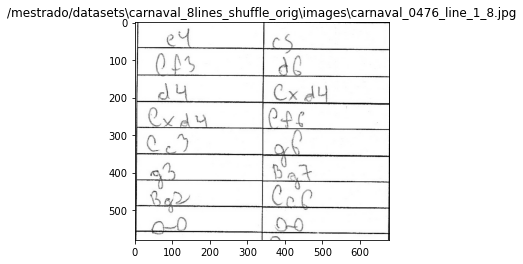

['d4' 'Nf6' 'g3' 'd5' 'c4' 'e6' 'Bg2' 'Be7' 'Nf3' 'O-O' 'O-O' 'Nbd7' 'Nc3'
 'dxc4' 'Qa4' 'Nb6']


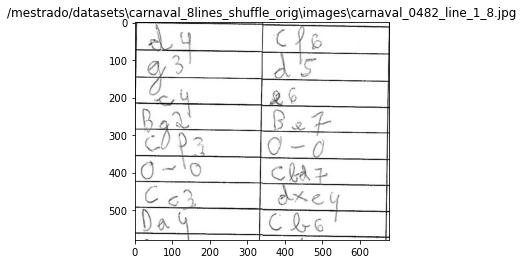

['d4' 'Nf6' 'c4' 'g6' 'f3' 'd5' 'cxd5' 'Nxd5' 'e4' 'Nb6' 'Nc3' 'Bg7' 'Be3'
 'O-O' 'Qd2' 'e5']


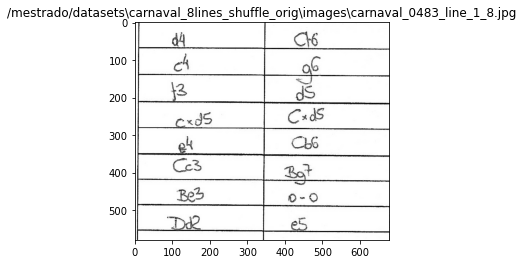

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'g6' 'Be3' 'Bg7' 'f3'
 'Nc6' 'Qd2' 'O-O']


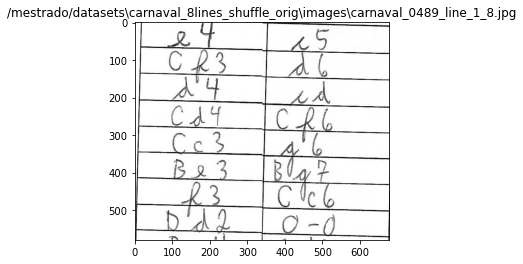

['e4' 'c5' 'Nf3' 'd6' 'Bb5+' 'Bd7' 'Bxd7+' 'Nxd7' 'O-O' 'Ngf6' 'Re1' 'e5'
 'c3' 'Be7' 'd3' 'O-O']


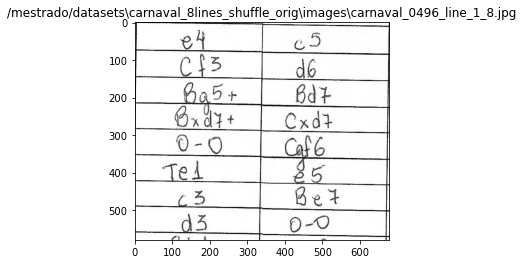

['Nf3' 'Nf6' 'b3' 'g6' 'Bb2' 'Bg7' 'e3' 'c5' 'c4' 'Nc6' 'd4' 'cxd4' 'Nxd4'
 'O-O' 'Be2' 'Nxd4']


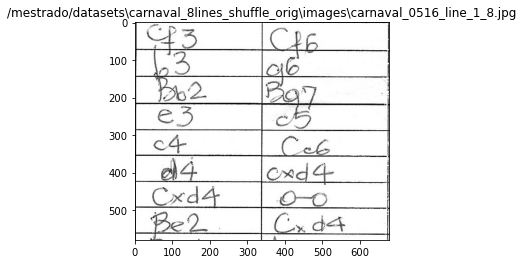

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bg5' 'Be7'
 'Qd2' 'a6' 'O-O-O' 'O-O']


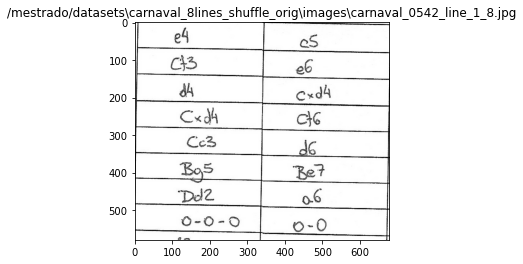

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Be2' 'e5' 'Nb3'
 'Be7' 'Bg5' 'Be6']


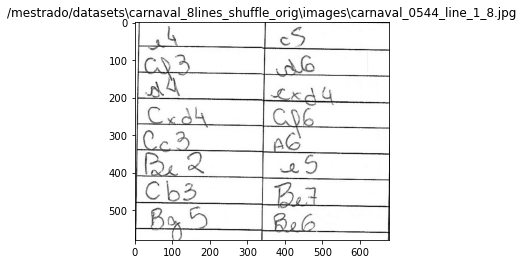

['d4' 'Nf6' 'c4' 'e6' 'Nc3' 'd5' 'cxd5' 'exd5' 'Bg5' 'Nbd7' 'e3' 'c6'
 'Bd3' 'Be7' 'Nge2' 'O-O']


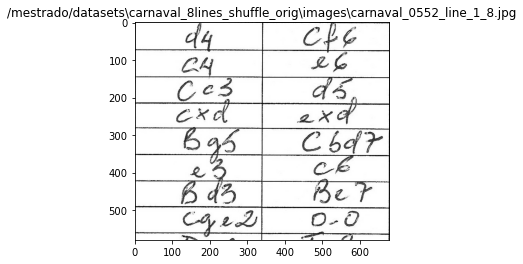

['d4' 'd5' 'c4' 'e6' 'Nc3' 'Be7' 'Bf4' 'Nf6' 'Nf3' 'O-O' 'e3' 'b6' 'cxd5'
 'exd5' 'Bd3' 'c5']


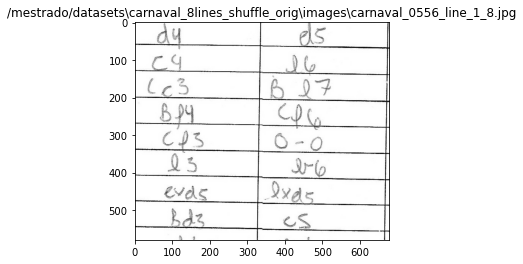

['e4' 'e6' 'd3' 'd5' 'Nd2' 'Nf6' 'Ngf3' 'dxe4' 'dxe4' 'Bc5' 'h3' 'c6' 'g3'
 'Qc7' 'c3' 'a5']


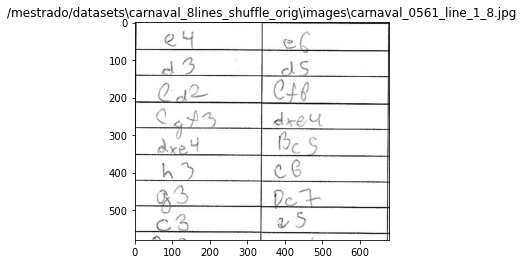

['e4' 'e5' 'Nf3' 'Nc6' 'd4' 'exd4' 'Nxd4' 'Qe7' 'Nc3' 'a6' 'Be3' 'Nf6'
 'f3' 'h6' 'Bc4' 'd6']


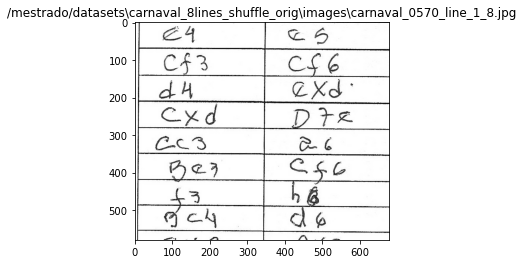

['e4' 'e6' 'd4' 'd5' 'Nc3' 'Nf6' 'e5' 'Nfd7' 'f4' 'c5' 'Nf3' 'Nc6' 'Be3'
 'a6' 'Qd2' 'cxd4']


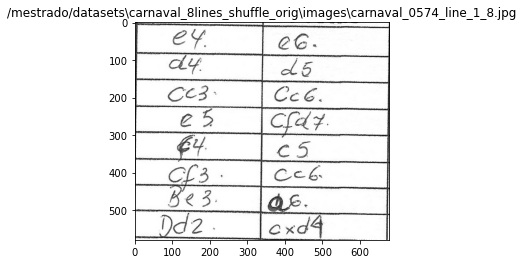

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bg5' 'Nbd7'
 'Qd2' 'a6' 'O-O-O' 'Qc7']


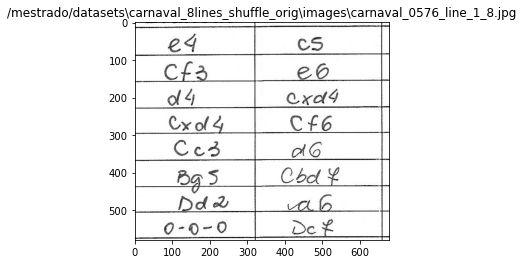

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nc6' 'Nxc6' 'bxc6' 'Nc3' 'Qc7'
 'Bd3' 'Nf6' 'O-O' 'd5']


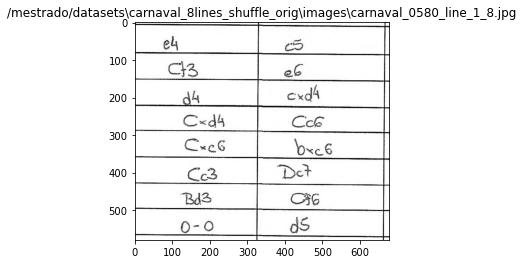

['e4' 'c5' 'Nf3' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'e5' 'Nb5' 'a6' 'Nd6+' 'Bxd6'
 'Qxd6' 'Qf6' 'Qd1' 'Qg6']


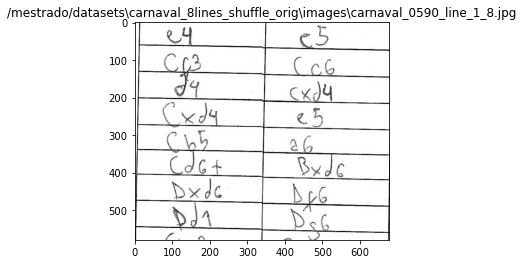

['Nf3' 'Nf6' 'c4' 'e6' 'g3' 'b6' 'Bg2' 'Bb7' 'O-O' 'd5' 'cxd5' 'Nxd5' 'b3'
 'Be7' 'Bb2' 'O-O']


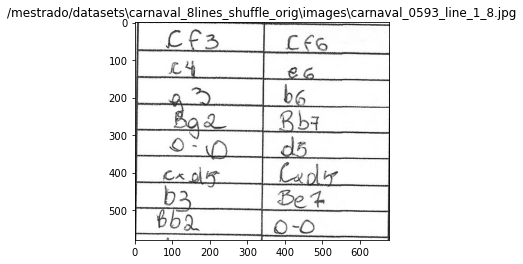

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'h3' 'e5' 'Nde2'
 'Be7' 'Bg5' 'Be6']


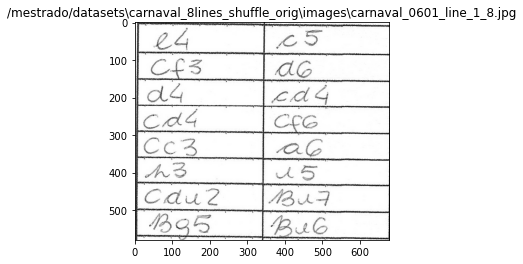

['d4' 'Nf6' 'c4' 'g6' 'Nc3' 'd5' 'b3' 'Bg7' 'Bf4' 'O-O' 'e3' 'c5' 'Bd3'
 'Nc6' 'Nge2' 'dxc4']


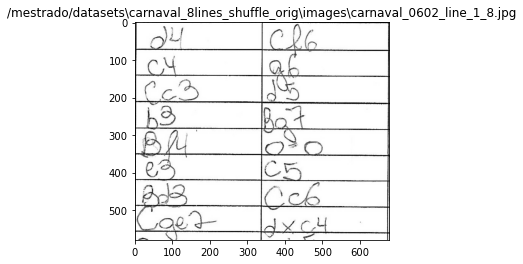

['e4' 'c5' 'Nf3' 'g6' 'd4' 'cxd4' 'Nxd4' 'Nc6' 'Nxc6' 'bxc6' 'Qd4' 'Nf6'
 'e5' 'Qa5+' 'Nc3' 'c5']


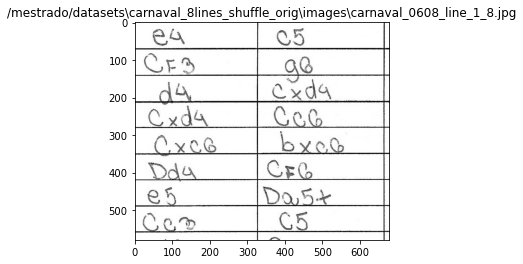

['Nf3' 'c5' 'c4' 'Nc6' 'd4' 'cxd4' 'Nxd4' 'g6' 'e4' 'Bg7' 'Be3' 'Nf6'
 'Nc3' 'd6' 'Be2' 'O-O']


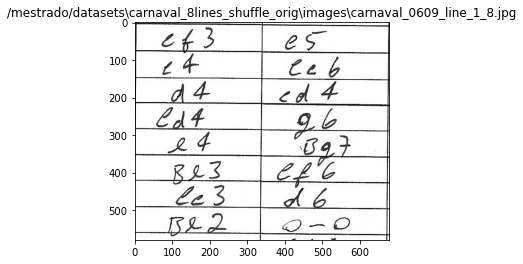

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nc6' 'Be3' 'Qc7' 'Nc3' 'a6'
 'Be2' 'Nf6' 'O-O' 'Bb4']


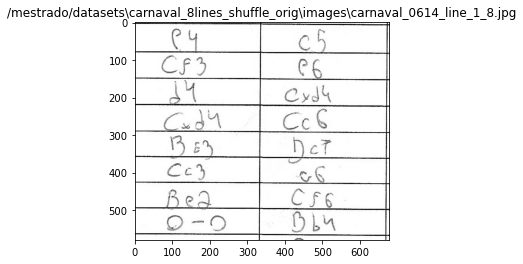

['d4' 'd5' 'Bg5' 'Nf6' 'Bxf6' 'exf6' 'e3' 'Bd6' 'Bd3' 'c6' 'Nd2' 'O-O'
 'h3' 'Re8' 'Ngf3' 'Nd7']


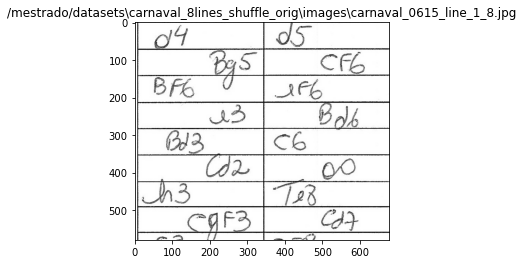

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Bd3' 'e5'
 'Nde2' 'Be6' 'f4' 'b5']


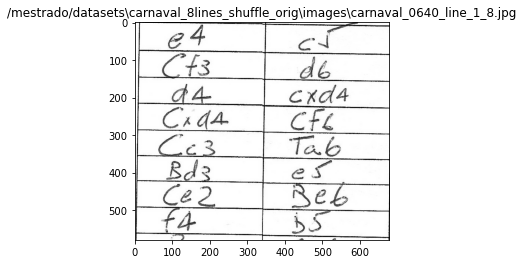

['e4' 'c5' 'Nf3' 'a6' 'Bc4' 'b5' 'Bxf7+' 'Kxf7' 'Ne5+' 'Ke6' 'Qh5' 'Nh6'
 'd4' 'cxd4' 'Nf7' 'Qc7']


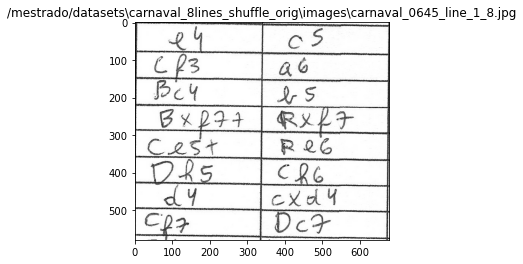

['e4' 'e5' 'Nf3' 'Nc6' 'Bb5' 'Nf6' 'O-O' 'd6' 'd4' 'Bd7' 'c3' 'Nxe4'
 'Bxc6' 'Bxc6' 'dxe5' 'Be7']


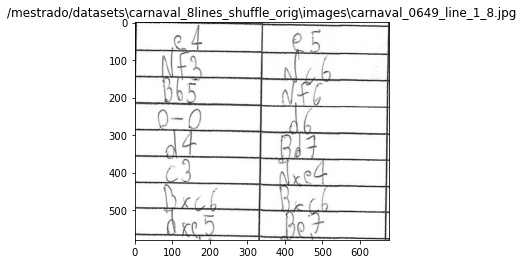

['e4' 'Nf6' 'e5' 'Nd5' 'c4' 'Nb6' 'd4' 'd6' 'exd6' 'cxd6' 'Nf3' 'g6' 'Nc3'
 'Bg7' 'Be2' 'Nc6']


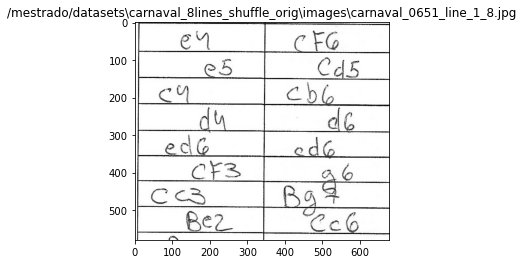

['e4' 'c5' 'f4' 'Nc6' 'Nf3' 'e6' 'Be2' 'Nf6' 'd3' 'd5' 'e5' 'Nd7' 'O-O'
 'f6' 'exf6' 'Nxf6']


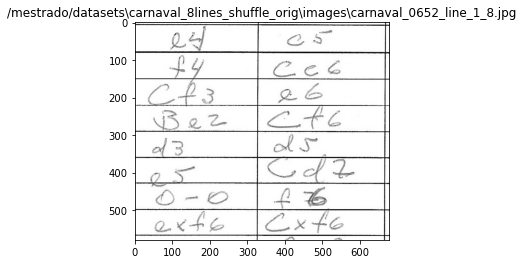

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nc6' 'Be3' 'Qc7' 'Nc3' 'a6'
 'Be2' 'Nf6' 'O-O' 'Bb4']


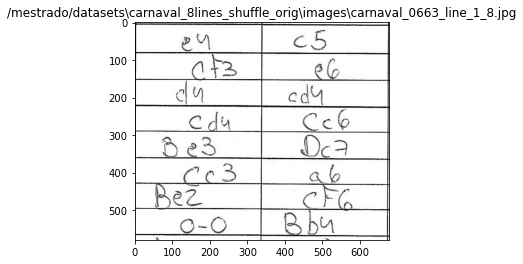

['e4' 'c5' 'Nf3' 'e6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'd6' 'Bg5' 'Be7'
 'Qd2' 'a6' 'O-O-O' 'O-O']


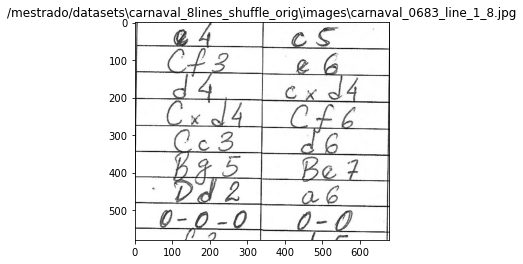

['e4' 'c5' 'Nf3' 'd6' 'd4' 'cxd4' 'Nxd4' 'Nf6' 'Nc3' 'a6' 'Bd3' 'e5'
 'Nde2' 'Be6' 'f4' 'b5']


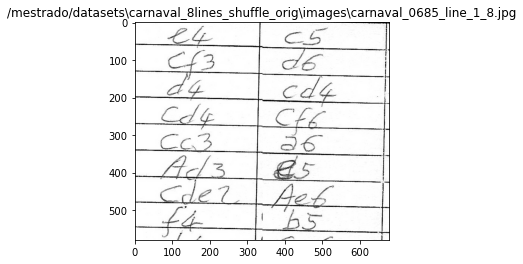

In [21]:
for i in range( 0, len( label_content)):
    s= ' '.join( label_content[i])
    if 'x' in s or '+' in s:
        print( label_content[i])
        show_image( all_image_content[i], all_images[i])